In [1]:
import jax
import jax.numpy as jnp

import equinox as eqx
import equinox.nn as nn

import numpy as np
import matplotlib.pyplot as plt

from vae.data import build_dataset
from vae.model.vqvae import VQVAE

dataloader, num_classes, n_samples, image_size = build_dataset(
    "CIFAR10", 
    "/Users/anton/source/vae/vae/train"
)


In [47]:
model = VQVAE(
    key=jax.random.PRNGKey(0),
    in_channels=3,
    num_embeddings=512,
    embedding_dim=64,
    ch=128,
    ch_mult=(1, 1, 2, 2, 4),
    num_res_blocks=2,
    beta_commit=0.25,
    ema_decay=0.99,
    epsilon=1e-5
)
batch, labels = next(iter(dataloader))
batch.shape

(1024, 32, 32, 3)

In [48]:
import numpy as np

class PCAProject:
    def __init__(self, x, n_components=2):
        self.n_components = n_components
        self.mean = np.mean(x, axis=0)
        
        # Center the data
        x_centered = x - self.mean
        U, S, Vt = np.linalg.svd(x_centered, full_matrices=False)
        
        self.components = Vt[:n_components]
        self.singular_values = S
        
    def __call__(self, x):
        x_centered = x - np.mean(x, axis=0)
        return x_centered @ self.components.T
    

## Visualizing codes

In [49]:
codes = model.quantizer.codebook
codes.shape

(512, 64)

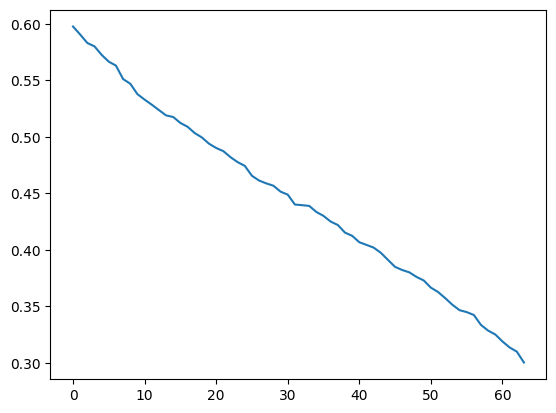

In [50]:
projection = PCAProject(codes)
codes_proj = projection(codes)

plt.plot(projection.singular_values)

## 0. Visualize Batch Encoding

In [51]:
x = batch[1]
print(x.shape)

enc = jax.vmap(model.encode)(batch)
#enc = enc.reshape(-1)
print(enc.shape)

(32, 32, 3)
(1024, 2, 2)


In [52]:
enc[0]

Array([[391, 249],
       [267, 181]], dtype=int32)

In [7]:
def _get_encoding(x):
    return model.encoder(x) 

def _get_quantized(x):
    enc = model.encoder(x)
    z_q, _, _ = model.quantizer.quantize(enc)
    z_q = z_q.reshape((-1, z_q.shape[-1]))
    return z_q

enc = jax.vmap(_get_encoding)(batch)
enc_q = jax.vmap(_get_quantized)(batch)
enc_proj = jax.vmap(projection)(enc_q)

enc.shape

(32, 2, 2, 8)

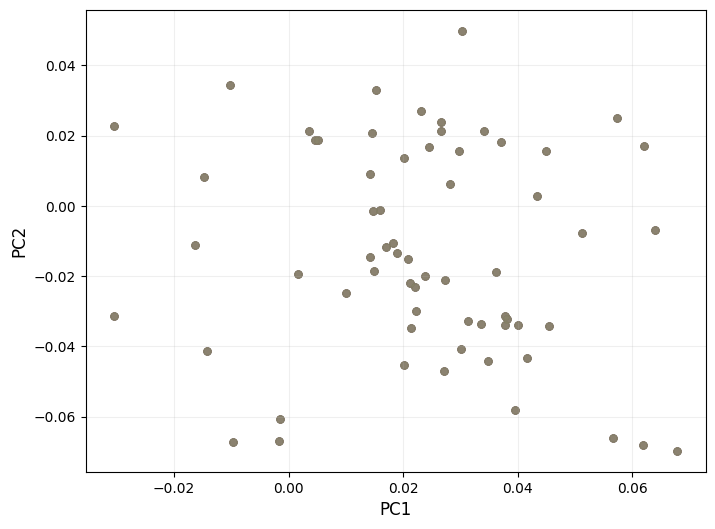

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))

for proj in enc_proj:
    ax.scatter(
        enc_proj[:, 0], 
        enc_proj[:, 1],
        alpha=0.1,
        s=30,
        linewidths=0.5,
    )


# Label axes
ax.set_xlabel('PC1', fontsize=12)
ax.set_ylabel('PC2', fontsize=12)
ax.grid(alpha=0.2)

## 1. Train Linear Classifier on Encodings

1. generate encodings

In [9]:
from jaxtyping import Int, Float, Array

class LinearClassifier(eqx.Module):
    proj: eqx.nn.Linear | eqx.nn.Sequential

    def __init__(self, dim_in, num_classes, key=jax.random.PRNGKey(0), 
                 use_bias=True, use_softmax=True):
        layers = [nn.Linear(dim_in, num_classes, use_bias=use_bias, key=key)]
        if use_softmax:
            layers += [eqx.nn.Lambda(jax.nn.softmax)]
        self.proj = nn.Sequential(layers)

    def __call__(self, x):
        return self.proj(x)
    

_get_flat_encoding = lambda x: _get_encoding(x).flatten() 

@jax.jit
def cross_entropy(
    y: Int[Array, " batch"], pred_y: Float[Array, "batch 10"]
) -> Float[Array, ""]:
    pred_y = jnp.take_along_axis(jnp.log(pred_y), jnp.expand_dims(y, 1), axis=1)
    return -jnp.mean(pred_y)

def loss(clf, x, y):
    pred_y = jax.vmap(clf)(x)
    return cross_entropy(y, pred_y)


enc = jax.vmap(_get_flat_encoding)(batch)
clf = LinearClassifier(enc.shape[-1], num_classes=10)
out = jax.vmap(clf)(enc)

eqx.filter_value_and_grad(loss)(clf, enc, labels)

(Array(2.3410237, dtype=float32),
 LinearClassifier(
   proj=Sequential(
     layers=(
       Linear(
         weight=f32[10,32],
         bias=f32[10],
         in_features=32,
         out_features=10,
         use_bias=True
       ),
       Lambda(fn=None)
     )
   )
 ))

i=0, train_loss=2.329416275024414
i=10, train_loss=2.1265456676483154
i=20, train_loss=2.0915708541870117
i=30, train_loss=2.0826339721679688
i=40, train_loss=2.079503297805786
i=50, train_loss=2.0779435634613037
i=60, train_loss=2.077479839324951
i=70, train_loss=2.077282428741455
i=80, train_loss=2.0772175788879395
i=90, train_loss=2.077192544937134


Text(0.5, 0, 'train step')

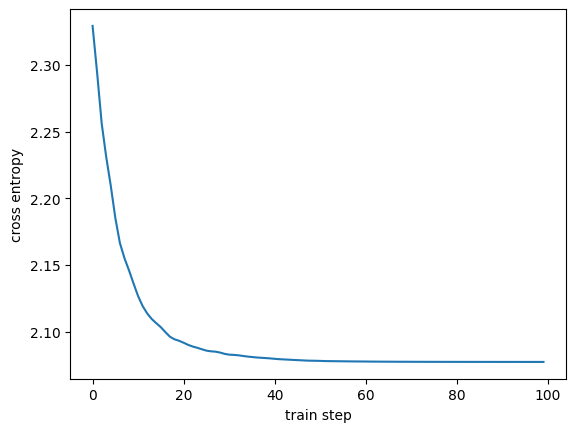

In [10]:
import optax 

opt = optax.adamw(learning_rate=0.1)
steps = 100

dataloader, _, _, image_size = build_dataset(
    "CIFAR10", 
    "/Users/anton/source/vae/vae/train",
    batch_size=1024
)

batch, labels = next(iter(dataloader))
enc = jax.vmap(_get_flat_encoding)(batch)

def train_clf(clf, opt, dataloader, n_samples=1024):
    opt_state = opt.init((eqx.filter(clf, eqx.is_array)))
    loss_vals = []

    @eqx.filter_jit
    def train_step(clf, opt_state, x, y):        
        loss_value, grads = eqx.filter_value_and_grad(loss)(clf, x, y)
        updates, opt_state = opt.update(grads, opt_state, eqx.filter(clf, eqx.is_array))

        clf = eqx.apply_updates(clf, updates)
        return clf, opt_state, loss_value
    
    #def infinite_dataloader():
    #    while True:
    #        yield from dataloader

    for i in range(steps):

        clf, opt_state, loss_value = train_step(clf, opt_state, enc, labels)
        loss_vals.append(loss_value)

        if i % 10 == 0:
            print(
                f"{i=}, train_loss={loss_value.item()}"
            )


    return loss_vals

loss_vals = train_clf(clf, opt, dataloader)
plt.plot(loss_vals)
plt.ylabel("cross entropy")
plt.xlabel("train step")

    




## 2. Codebook Metrics
1. final linear train loss

In [11]:
x1, x2 = batch[:16], batch[16:32]

In [12]:
_batch_encoding = jax.vmap(_get_flat_encoding)
_batch_quantized = jax.vmap(_get_quantized)
_batch_indices = jax.vmap(model.encode)
enc1, enc2 = _batch_encoding(x1), _batch_encoding(x2)
z1, z2 = _batch_quantized(x1), _batch_quantized(x2)
idx1, idx2 = _batch_indices(x1), _batch_indices(x2)

In [13]:
z1.shape

(16, 4, 8)

(array([1., 2., 1., 5., 3., 1., 1., 1., 0., 1.]),
 array([ 52.25      ,  88.09999847, 123.94999695, 159.79998779,
        195.6499939 , 231.5       , 267.34997559, 303.19998169,
        339.04998779, 374.8999939 , 410.75      ]),
 <BarContainer object of 10 artists>)

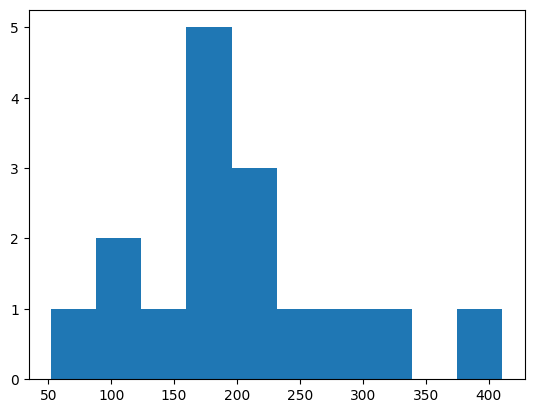

In [14]:
hamm = jnp.abs(idx1 - idx2)
plt.hist(jnp.mean(hamm, axis=(-1, -2)))

In [22]:
def norm(x): return jnp.sqrt(jnp.sum((x)**2))
def sqdist(x1, x2): return jnp.sum((x1 - x2)**2)
def cossim(x1, x2): return jnp.sum(x1 * x2) / (norm(x1) * norm(x2))

tril_idx = jax.numpy.tril_indices(len(z1))

def compute_quant_cos_sim(zq1, zq2):
    return jax.vmap(cossim)(zq1, zq2).clip(-1, 1)

def compute_batch_sims(zq1, zq2):
    return jax.vmap(lambda i, j: compute_quant_cos_sim(z1[i], z2[j]), in_axes=(0, 0))(*tril_idx)

Text(0, 0.5, 'Count')

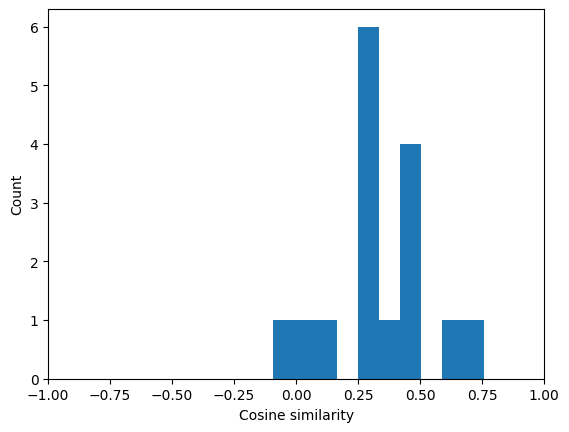

In [35]:
B = z1.shape[0]

cos_sims = jax.vmap(compute_quant_cos_sim)(z1, z2)
cos_sims = jax.vmap(cossim)(z1.reshape(B, -1), z2.reshape(B, -1))
plt.hist(cos_sims)
plt.xlim(-1, 1)
plt.xlabel("Cosine similarity")
plt.ylabel("Count")

## 3. SimCLR Loss

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import os

def get_simclr_augmentation(image_size):
    """SimCLR augmentation pipeline from the paper."""
    
    # Color jitter parameters from SimCLR paper
    color_jitter = transforms.ColorJitter(
        brightness=0.8, 
        contrast=0.8, 
        saturation=0.8, 
        hue=0.2
    )
    
    augmentation = transforms.Compose([
        transforms.RandomResizedCrop(image_size, scale=(0.08, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomApply([color_jitter], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        # Optional: Gaussian blur (used in SimCLR v2)
        # transforms.RandomApply([transforms.GaussianBlur(kernel_size=image_size//20*2+1, sigma=(0.1, 2.0))], p=0.5),
        transforms.ToTensor(),
    ])
    
    return augmentation